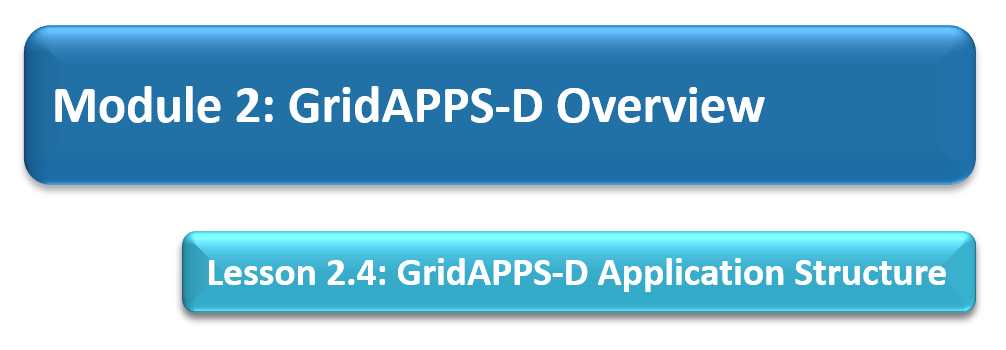

---

# GridAPPS-D Application Structure

This tutorial introduces the structure of a GridAPPS-D Application. A sample application is broken down into nine steps with detailed explanation of how each API is called by the application

__Learning Objectives:__

At the end of the tutorial, the user should be able to

* 
* 
* 

## Getting Started

Before running any of the sample routines in this tutorial, it is first necessary to start the GridAPPS-D Platform and establish a connection to this notebook so that we can start passing calls to the API.

_Open the Ubuntu terminal and start the GridAPPS-D Platform if it is not running already:_

`cd gridappsd-docker`

~/gridappsd-docker$ `./run.sh -t develop`

_Once containers are running,_

gridappsd@[container]:/gridappsd$ `./run-gridappsd.sh`

---


## Table of Contents

* [1. A First Course in GridAPPSD-Python](#1.-A-First-Course-in-GridAPPSD-Python)


* [2. Building Blocks of an Application](#2.-Building-Blocks-of-an-Application)
    * [2.1. Import Required Python Libraries](#2.1.-Import-Required-Python-Libraries)
    * [2.2. Import Required GridAPPS-D Libraries](#2.2.-Import-Required-GridAPPS-D-Libraries)
    * [2.3. Establish a Connection to the GridAPPS-D Platform](#2.3.-Establish-a-Connection-to-the-GridAPPS-D-Platform)
    * [2.4. Pass a Simple API Call](#2.4.-Pass-a-Simple-API-Call)

---

## 1. Application Structure

__2) Start a simulation in the GridAPPS-D Viz:__

The Simulation API calls covered in this lesson need to be passed to an active simulation. For the purposes of this tutorial, we will use the GridAPPS-D Viz at [localhost:8080](http://localhost:8080/) to start a simulation of the IEEE 123 Node model with a 3600 sec simulation time. 

The steps for starting a simulation were covered in [Lesson 2.5, Section 3](Lesson%202.5.%20Simulation%20API%20-%20Running%20Simulations.ipynb#3.2.1.-"power_system_config":). 

After starting the simulation, paste the simulation_id into the code block below by clicking on the simulation_id. This will automatically copy the simulation_id to your computer's clipboard.

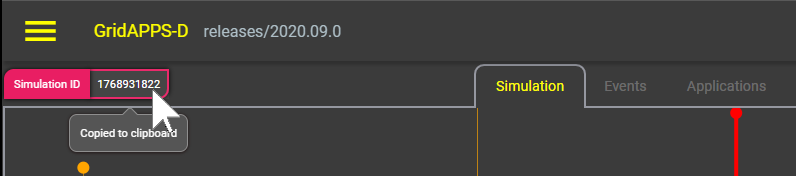

When your application is containerized in Docker and registered with the GridAPPS-D Platform using the docker-compose file, the simulation_id and feeder model mRID as passed as part of the application start call. For this notebook, that information needs to be copied and pasted into the first code block below. 

In [ ]:
# Import GridAPPSD-Python Library:
from gridappsd import GridAPPSD

# Paste Simulation ID into this variable:
viz_simulation_id = "1788908680"

# Simulation running on IEEE 123 node model:
model_mrid = "_C1C3E687-6FFD-C753-582B-632A27E28507"

# Establish connection to GridAPPS-D Platform:
gapps = GridAPPSD(viz_simulation_id, "('localhost', 61613)", username='system', password='manager')
assert gapps.connected

Could not connect to host localhost, port 61613
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.8/site-packages/stomp/transport.py", line 737, in attempt_connection
    self.socket = socket.create_connection(host_and_port, self.__timeout)
  File "/home/ubuntu/anaconda3/lib/python3.8/socket.py", line 808, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/lib/python3.8/socket.py", line 796, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused
Could not connect to host localhost, port 61613
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.8/site-packages/stomp/transport.py", line 737, in attempt_connection
    self.socket = socket.create_connection(host_and_port, self.__timeout)
  File "/home/ubuntu/anaconda3/lib/python3.8/socket.py", line 808, in create_connection
    raise err
  File "/home/ubuntu/anaconda3/lib/python3.8/socket.py", line 796, in create_connection
    so

## 2. Querying for the Power System Model

The first portion of a GridAPPS-D application is series of queries to the PowerGrid Models API to obtain information about the power system model. 

Because GridAPPS-D applications are designed to be portable across numerous power system models without any code modification, the application must query the Blazegraph database and create a set of local variables that contain the information needed by the app to run its internal code. 

An application will query for the various pieces of power system equipment relevant to its objective (e.g. a VVO app will be interested in regulators and capacitors, while a FLISR app will be interested in switches and reclosers present in the model). The query will typically include requests for information about the names, location, mRIDS, and electrical parameters for the various pieces of equipment needed by the application.. 

### 2.1. Information flow

The figure below shows the information flow involved in making a query for the power system model.

The query is sent using `gapps.get_response(topic, message)` on a queue channel (explained in [Lesson 3.1](3.1%20--%20Lesson%203.1%20--%20API%20Communication%20Channels.ipynb)) with a response expected back from the platform within the specified timeout period.

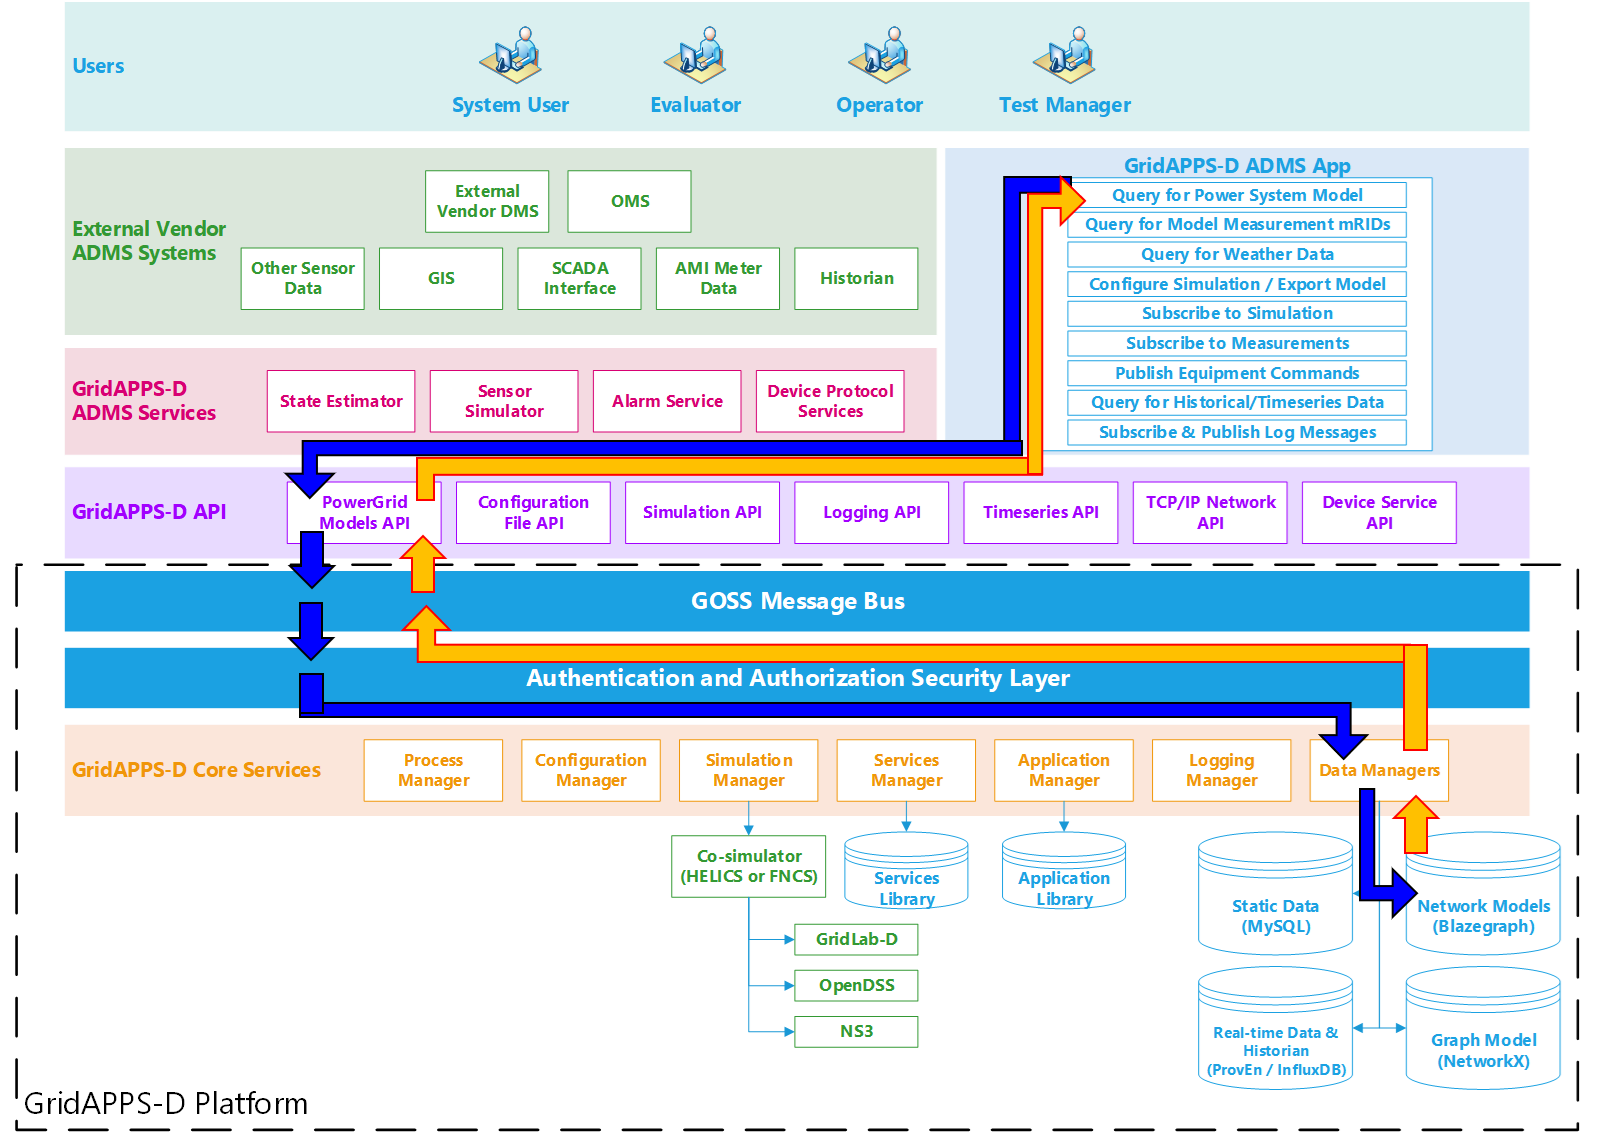

__Application passes query to GridAPPS-D Platform__

First, the application creates a query message for requesting information about the desired power system components in the format of a JSON string or equivalant Python dictionary object. The syntax of this message is explained in detail in [Lesson 3.3](3.3%20--%20Lesson%203.3%20--%20Using%20the%20PowerGrid%20Models%20API.ipynb). 

The application then passes the query through the PowerGrid Models API to the GridAPPS-D Platform, which publishes it to a queue channel on the GOSS Message Bus. If the app is authenticated and authorized to pass queries, the query message is delivered to the data managers, which obtain the desired information from the Blazegraph Database. 

__GridAPPS-D Platform responds to Application query__

The data managers then publish the response from the Blazegraph Database to the appropriate queue channel. The PowerGrid Models API then returns the desired information back to the application as a JSON message or equivalant Python dictionary object.

### 2.2. Sample App code
Below is a sample query of how the application will use the PowerGrid Models API to query for the details associated for all the switches in the feeder. 

In [ ]:
from gridappsd import topics as t

message = {
    "modelId": model_mrid,
    "requestType": "QUERY_OBJECT_DICT",
    "resultFormat": "JSON",
    "objectType": "LoadBreakSwitch"
}

response_obj = gapps.get_response(t.REQUEST_POWERGRID_DATA, message)
switch_dict = response_obj["data"]

# Filter to get mRID for switch SW2:
for index in switch_dict:
    if index["IdentifiedObject.name"] == 'sw2':
        sw_mrid = index["IdentifiedObject.mRID"]

print(switch_dict[0]) # Print dictionary for first switch

print('mRID of sw2 is ',sw_mrid)

---

## 3. Querying for Measurement mRIDs

The next portion of a GridAPPS-D application is series of queries to the PowerGrid Models API to obtain information about the measurements associated with various pieces of equipment the application is interested in. Due to structure of the Common Information Model (introduced in [Lesson 2.6](2.6%20--%20Lesson%202.6%20--%20Common%20Information%20Model.ipynb)), there exist a separate set of objects associated with the positive-neutral-voltage (PNV), volt-ampere (VA), and position measurements (POS) for each line, transformer, switch, etc.

Because GridAPPS-D applications are designed to be portable across numerous power system models without any code modification, the application must query the Blazegraph Database and create a set of local variables that contain the unique mRIDS of each measurement needed by the app to run its internal code. In a subsequent step, the app will use these measurement mRIDs to subscribe to the live streaming data issued by the simulation.


### 3.1. Information Flow

The figure below shows the information flow involved in making a query for the power system model. 

The query is sent using `gapps.get_response(topic, message)` on a queue channel (explained in [Lesson 3.1](3.1%20--%20Lesson%203.1%20--%20API%20Communication%20Channels.ipynb)) with a response expected back from the platform within the specified timeout period.

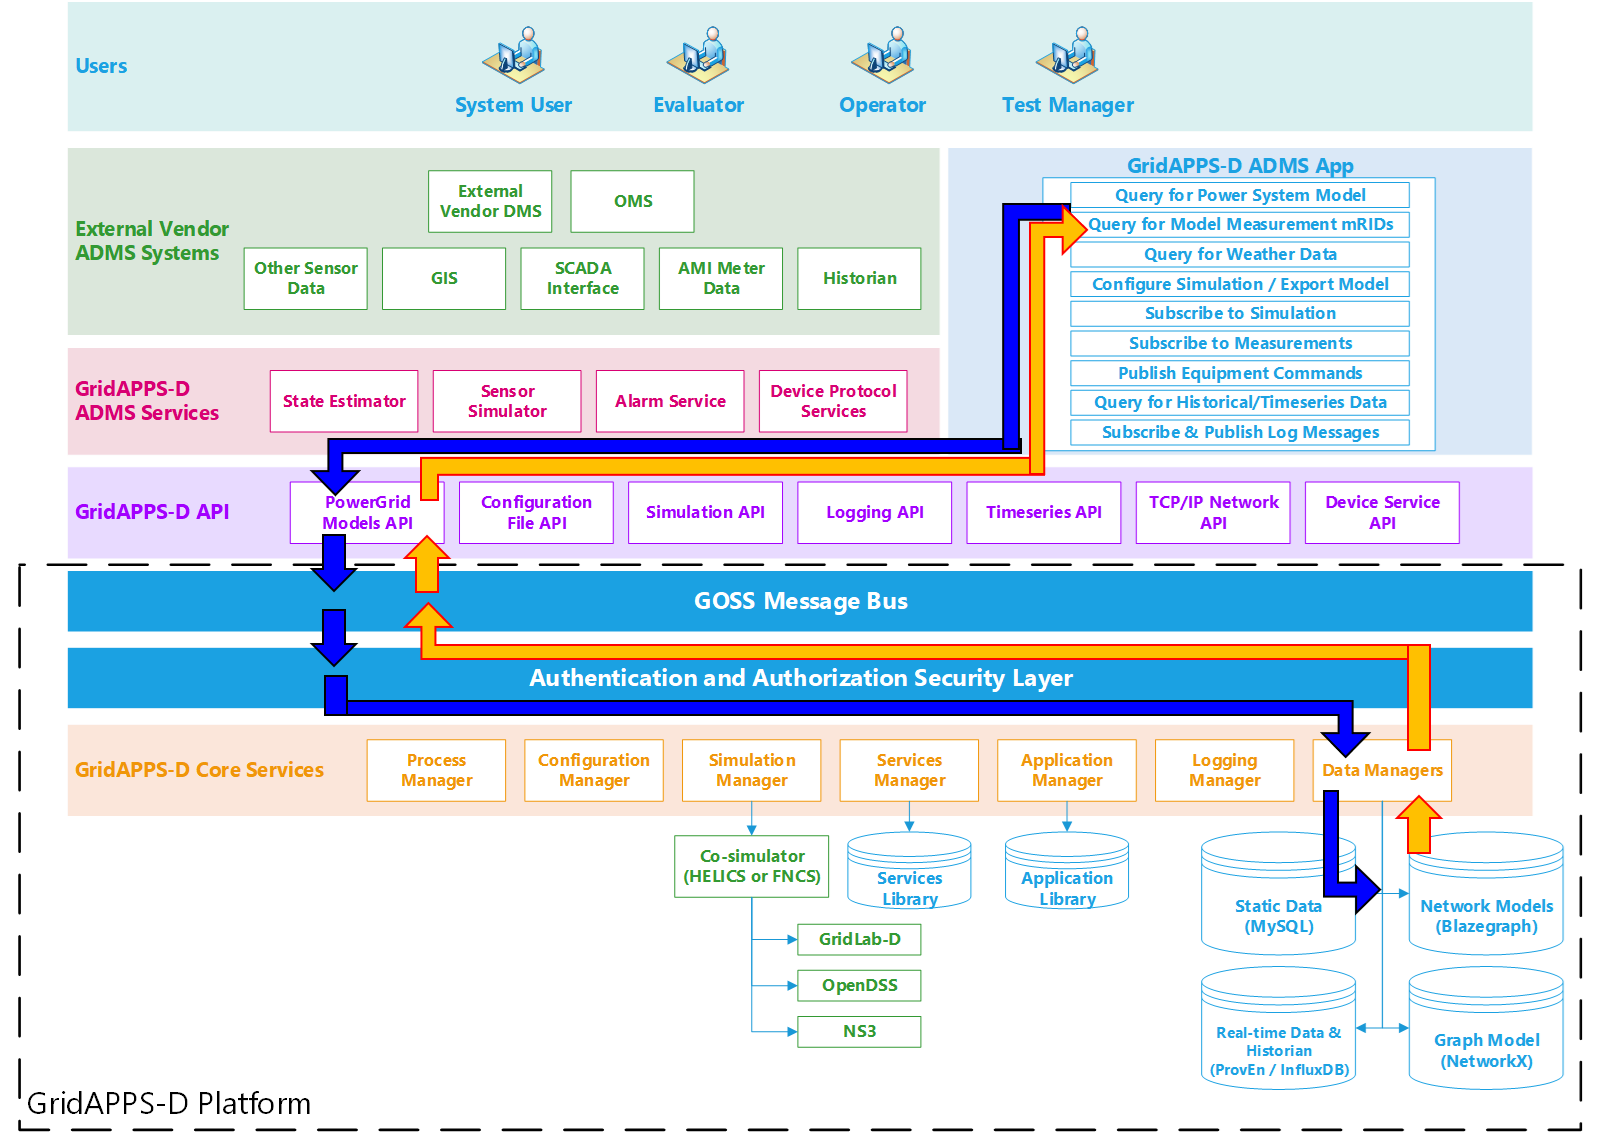

The figure below shows the information flow involved in making a query for the power system model. 

__Application passes query to GridAPPS-D Platform__

First, the application creates a query message for requesting information about the desired power system components in the format of a JSON string or equivalant Python dictionary object. The syntax of this message is explained in detail in [Lesson 3.3](3.3%20--%20Lesson%203.3%20--%20Using%20the%20PowerGrid%20Models%20API.ipynb). 

The application then passes the query through the PowerGrid Models API to the GridAPPS-D Platform, which publishes it to a queue channel on the GOSS Message Bus. If the app is authenticated and authorized to pass queries, the query message is delivered to the data managers, which obtain the desired information from the Blazegraph Database. 

__GridAPPS-D Platform responds to Application query__

The data managers then publish the response from the Blazegraph Database to the appropriate queue channel. The PowerGrid Models API then returns the desired information back to the application as a JSON message or equivalant Python dictionary object.

Below is a sample query of how the application will use the PowerGrid Models API to query for the measurement mRIDs of all switches in the power system model

In [ ]:
message = {
    "modelId": model_mrid,
    "requestType": "QUERY_OBJECT_MEASUREMENTS",
    "resultFormat": "JSON",
    "objectType": "LoadBreakSwitch"
}

response_obj = gapps.get_response(t.REQUEST_POWERGRID_DATA, message) # Pass query to PowerGrid Models API
measurements_obj = response_obj["data"]

global Pos_obj # Define global python dictionary of position measurements
Pos_obj = [k for k in measurements_obj if k['type'] == 'Pos'] # Filter measurements to just switch positions

print(Pos_obj[0]) # Print switch position measurement mRID for first switch

---

## 4. Querying for Weather Data

The next portion of a GridAPPS-D application is series of queries to the Timeseries API to obtain information about the weather data for the current time, including irradiation, temperature, etc. This information can be used for solar forecasting, load forecasting, etc.

Because GridAPPS-D applications are designed to be portable across numerous power system models without any code modification, the application must query the Timeseries Influx Database and create a set of local variables that contain the weather data needed by the app to run its internal code.


### 4.1. Information Flow

The figure below shows the information flow involved in making a query for the power system model. 

The query is sent using `gapps.get_response(topic, message)` on the Timeseries queue channel (explained in [Lesson 3.1](3.1%20--%20Lesson%203.1%20--%20API%20Communication%20Channels.ipynb)) with a response expected back from the platform within the specified timeout period.

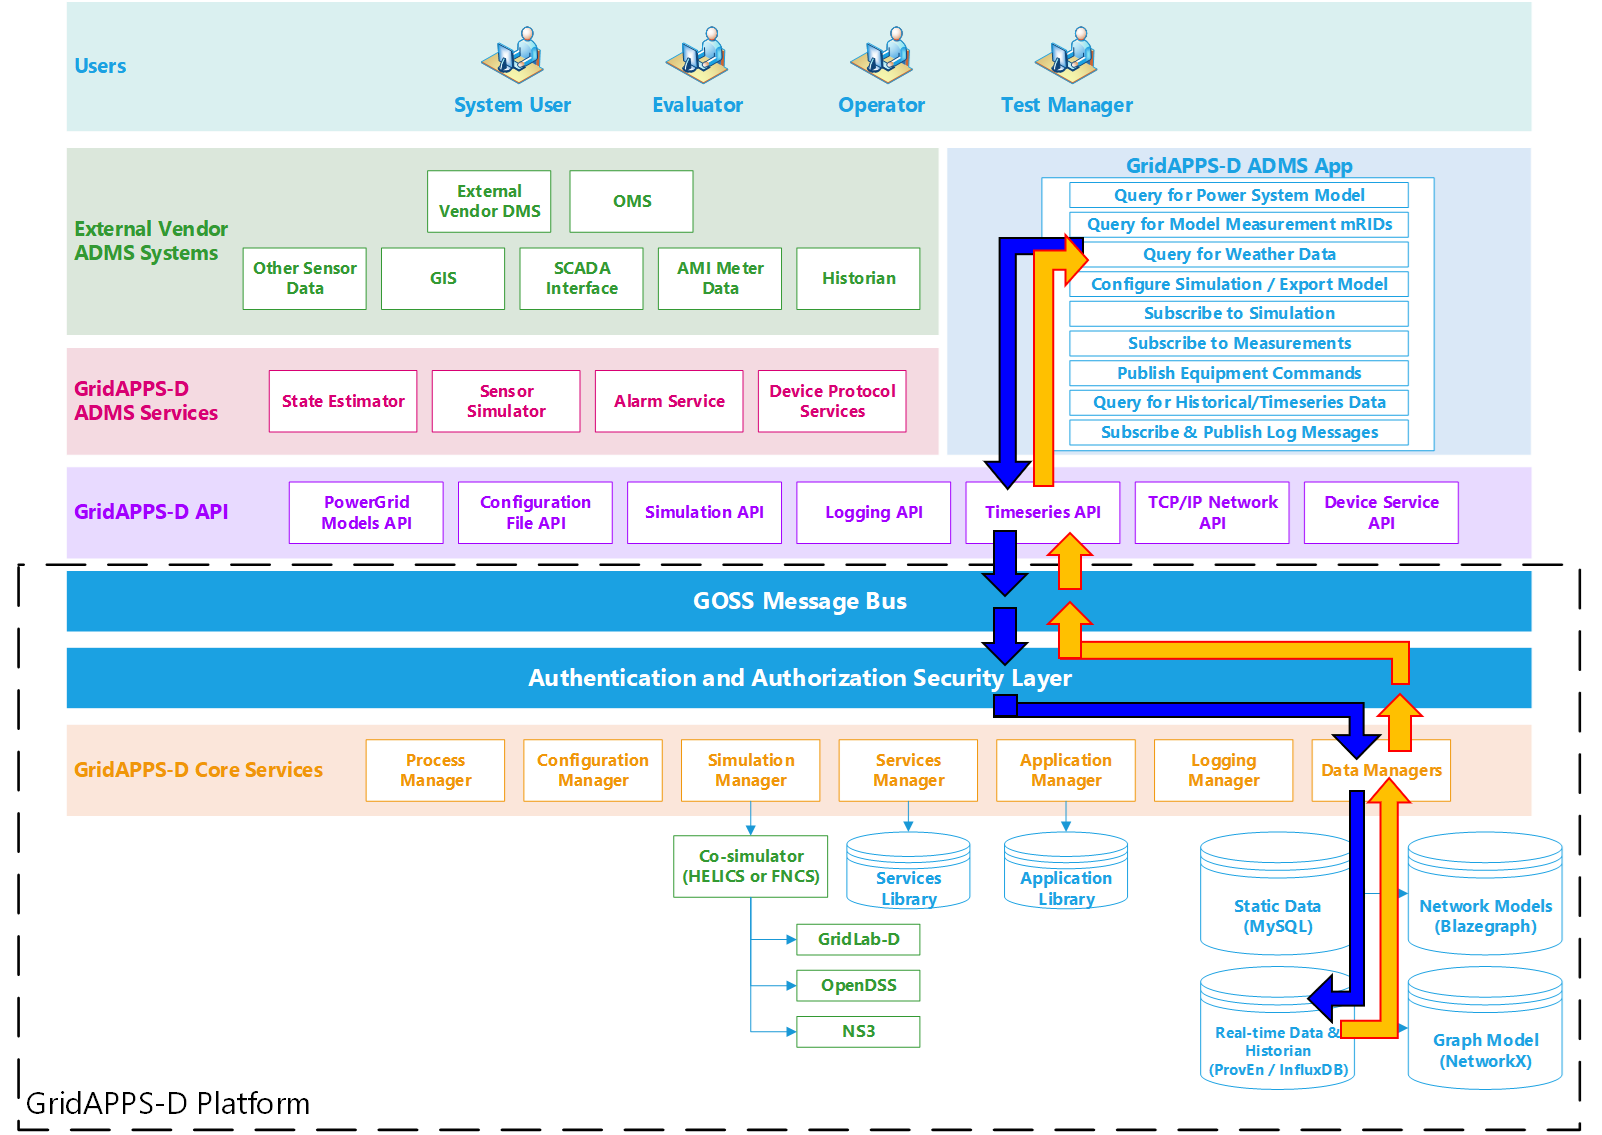


__Application passes query to GridAPPS-D Platform__

First, the application creates a query message for requesting information about the desired power system components in the format of a JSON string or equivalant Python dictionary object. The syntax of this message is explained in detail in [Lesson 3.7](3.7%20--%20Lesson%203.7%20--%20Using%20the%20Timeseries%20API.ipynb). 

The application then passes the query through the Timeseries API to the GridAPPS-D Platform, which publishes it to a queue channel on the GOSS Message Bus. If the app is authenticated and authorized to pass queries, the query message is delivered to the Data Managers, which obtain the desired information from the Timeseries Influx Database. 

__GridAPPS-D Platform responds to Application query__

The Data Managers then publish the response from the Timeseries Influx Database to the appropriate queue channel. The Timeseries API then returns the desired information back to the application as a JSON message or equivalant Python dictionary object.

### 4.2. Sample App Code

Below is a sample query to the Timeseries API requesting all weather data between a certain startTime and endTime (given in unix absolute time). The application can then use that weather data to feed its internal forecasting algorithm.

In [ ]:
# Use queryFilter of "startTime" and "endTime"
message = {
    "queryMeasurement":"weather",
    "queryFilter":{"startTime":"1357048800000000",
                   "endTime":"1357048860000000"},
    "responseFormat":"JSON"
}

response_obj = gapps.get_response(t.TIMESERIES, message) # Pass query to Timeseries API 
weather_obj = response_obj["data"]

print(weather_obj[1]) # Print first line of weather data

---

## 5. Configuring a Parallel Simulation

Some applications may choose to run parallel simulations (similar to a digital twin), either within the GridAPPS-D platform or by exporting the model to OpenDSS, GridLAB-D, etc. This is accomplished through one or more queries to the Configuration File API to create a simulation configuration file and/or exported power system model.

The simulation configuration file contains all the necessary info to create a new simulation, including the power system model, date/time, and variations from the default basecase (i.e. re-dispatched DERs and switches that have been opened/closed).

The exported power system model is the entire model as a set of GLM or DSS that can be saved to an external file and then solved with a different power flow solver outside of the GridAPPS-D Platform.

### 5.1. Information Flow

The figure below shows the information flow involved in making a query for the power system model. 

The query is sent using `gapps.get_response(topic, message)` on the Configuration File queue channel (explained in [Lesson 3.1](3.1%20--%20Lesson%203.1%20--%20API%20Communication%20Channels.ipynb)) with a response expected back from the platform within the specified timeout period.

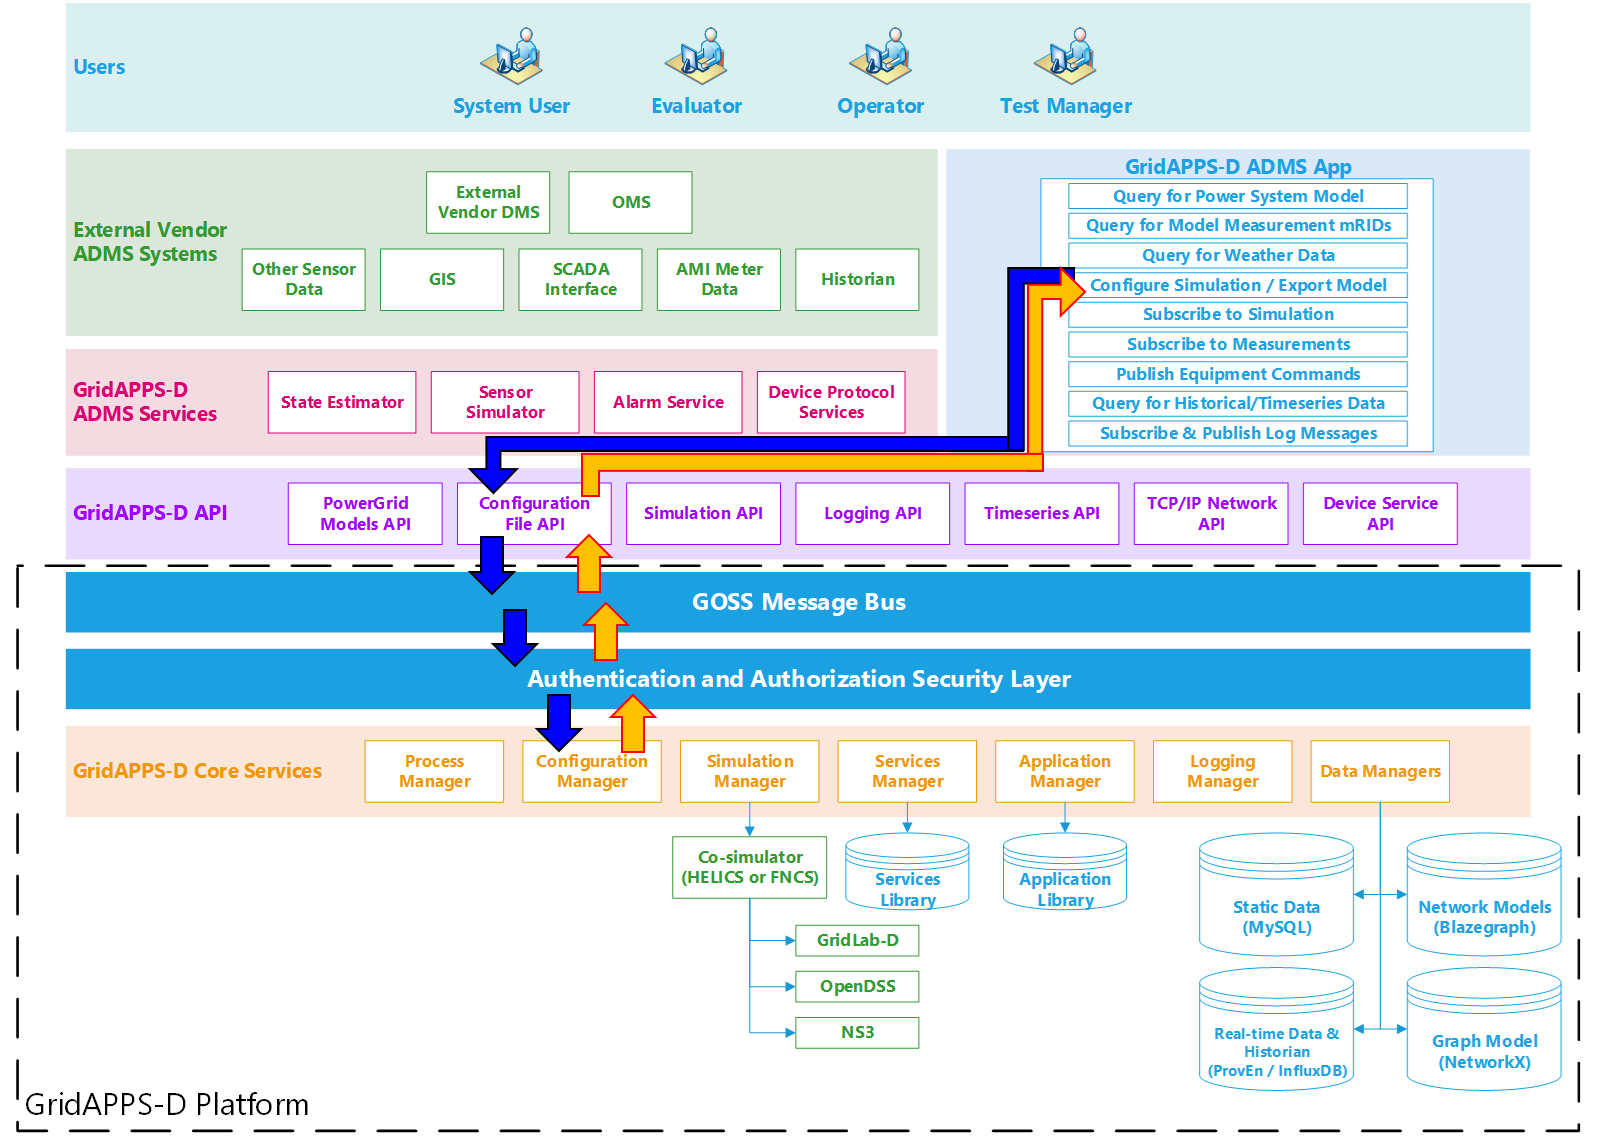

__Application passes query to GridAPPS-D Platform__

First, the application creates a query message for requesting information about the desired power system configuration in the format of a JSON string or equivalant Python dictionary object. The syntax of this message is explained in detail in [Lesson 3.4](3.4%20--%20Lesson%203.4%20--%20Using%20the%20Configuration%20File%20API.ipynb). 

The application then passes the query through the Configuration File API to the GridAPPS-D Platform, which publishes it to a queue channel on the GOSS Message Bus. If the app is authenticated and authorized to pass queries, the query message is delivered to the Configuration Manager.

__GridAPPS-D Platform responds to Application query__

The Configuration Manager obtains the CIM XML file for the desired power system model and then converts it to the desired output format with all of the requested changes to the model. The Configuration File API then returns the desired information back to the application as a JSON message (for Y-Bus or partial models) or export the files to the directory specified in the 

### 5.2. Sample App Code

Below is a sample query showing how an application would make a query through the Configuration File API to change all loads to constant current loads, convert the power system model to a set of OpenDSS files, and export them to the directory /tmp/dsssimulation.

In [ ]:
topic = "goss.gridappsd.process.request.config"

message = {
    "configurationType": "DSS All",
    "parameters": {
        "directory": "/tmp/dsssimulation/",
        "model_id": model_mrid,
        "simulation_id": "12345678",
        "simulation_name": "ieee13",
        "simulation_start_time": "1518958800",
        "simulation_duration": "60",
        "simulation_broker_host": "localhost",
        "simulation_broker_port": "61616",
        "schedule_name": "ieeezipload",
        "load_scaling_factor": "1.0",
        "z_fraction": "0.0",
        "i_fraction": "1.0",
        "p_fraction": "0.0",
        "solver_method": "NR" }
}

gapps.get_response(topic, message)

---

## 6. Processing Measurements & App Core Algorithm

The next portion of a GridAPPS-D application is the measurement processing and core algorithm section. This section is built as either a class or function definition with prescribed arguments. Each has its advantages and disadvantages:

* The function-based approach is simpler and easier to implement. However, any parameters obtained from other APIs or methods to be used inside the function currently need to be defined as global variables. 

* The class-based approach is more complex, but also more powerful. It provides greater flexibility in creating additional methods, arguments, etc.

In [ ]:
def demoSubscription1(header, message):
    # Extract time and measurement values from message          
    timestamp = message["message"]["timestamp"]
    meas_value = message["message"]["measurements"]
    
    meas_mrid = list(meas_value.keys()) #obtain list of all mrid from message
    
    # Filter to measurements with value of zero
    open_switches = []
    for index in Pos_obj:
        if index["measid"] in meas_value:
            mrid = index["measid"]
            power = meas_value[mrid]
            if power["value"] == 0:
                open_switches.append(index["eqname"])
    
    # Print message to command line
    print("............")
    print("Number of open switches at time", timestamp, ' is ', len(set(open_switches)))

---

## 7. Subscribing to Simulation Output

The next portion of a GridAPPS-D application is series of queries to the Timeseries API to obtain information about the weather data for the current time, including irradiation, temperature, etc. This information can be used for solar forecasting, load forecasting, etc.

Because GridAPPS-D applications are designed to be portable across numerous power system models without any code modification, the application must query the Timeseries Influx Database and create a set of local variables that contain the weather data needed by the app to run its internal code.


### 7.1. Information Flow

The figure below shows the information flow involved in subscribing to the simulation output.

The subscription request is sent using `gapps.subscribe(topic, message)` on the specific Simulation topic channel (explained in [API Communication Channels](3.1%20--%20Lesson%203.1%20--%20API%20Communication%20Channels.ipynb)). No immediate response is expected back from the platform. However, after the next simulation timestep, the Platform will continue to deliver a complete set of measurements back to the application for each timestep until the end of the simulation.

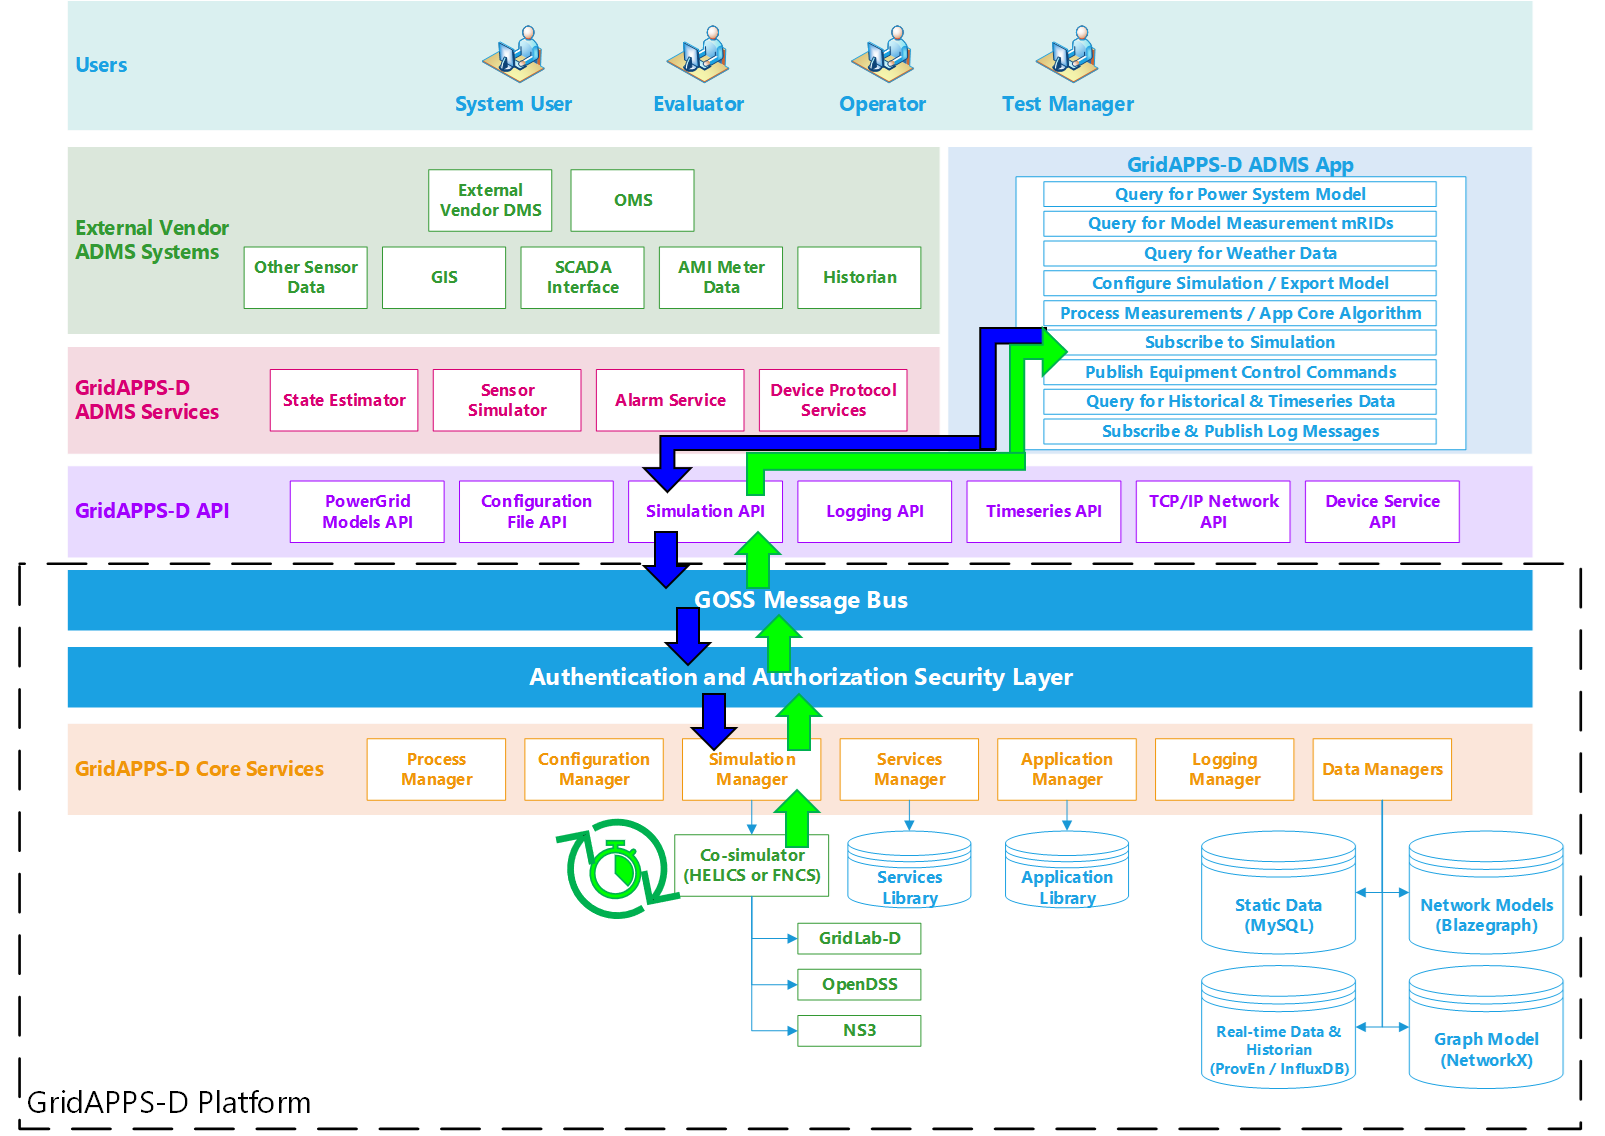

__Application passes query to GridAPPS-D Platform__

First, the application creates a query message for requesting information about the desired power system configuration in the format of a JSON string or equivalant Python dictionary object. The syntax of this message is explained in detail in [Lesson 3.4](3.4%20--%20Lesson%203.4%20--%20Using%20the%20Configuration%20File%20API.ipynb). 

The application then passes the query through the Configuration File API to the GridAPPS-D Platform, which publishes it to a queue channel on the GOSS Message Bus. If the app is authenticated and authorized to pass queries, the query message is delivered to the data managers, which obtain the desired information from the Blazegraph Database. 

__GridAPPS-D Platform responds to Application query__

The data managers then publish the response from the Blazegraph Database to the appropriate queue channel. The Timeseries API then returns the desired information back to the application as a JSON message or equivalant Python dictionary object.

### 7.2. Sample App Code

Below is an example of how an application subscribes to the GridAPPS-D simulation output using the function or class definition created as part of the [Measurement Processing / App Core](#6.-Processing-Measurements-&-App-Core-Algorithm)

In [ ]:
from gridappsd.topics import simulation_output_topic

output_topic = simulation_output_topic(viz_simulation_id)

gapps.subscribe(output_topic, demoSubscription1)

---

## 8. Publishing Equipment Commands

The next portion of a GridAPPS-D App is publsihing equipment control commands based on the optimization results or objectives of the app algorithm. 

Depending on the preference of the developer, this portion can be a separate function definition, or included as part of the main class definition as part of the [Measurement Processing / App Core](#6.-Processing-Measurements-&-App-Core-Algorithm) class definition described earlier.

### 8.1. Information Flow



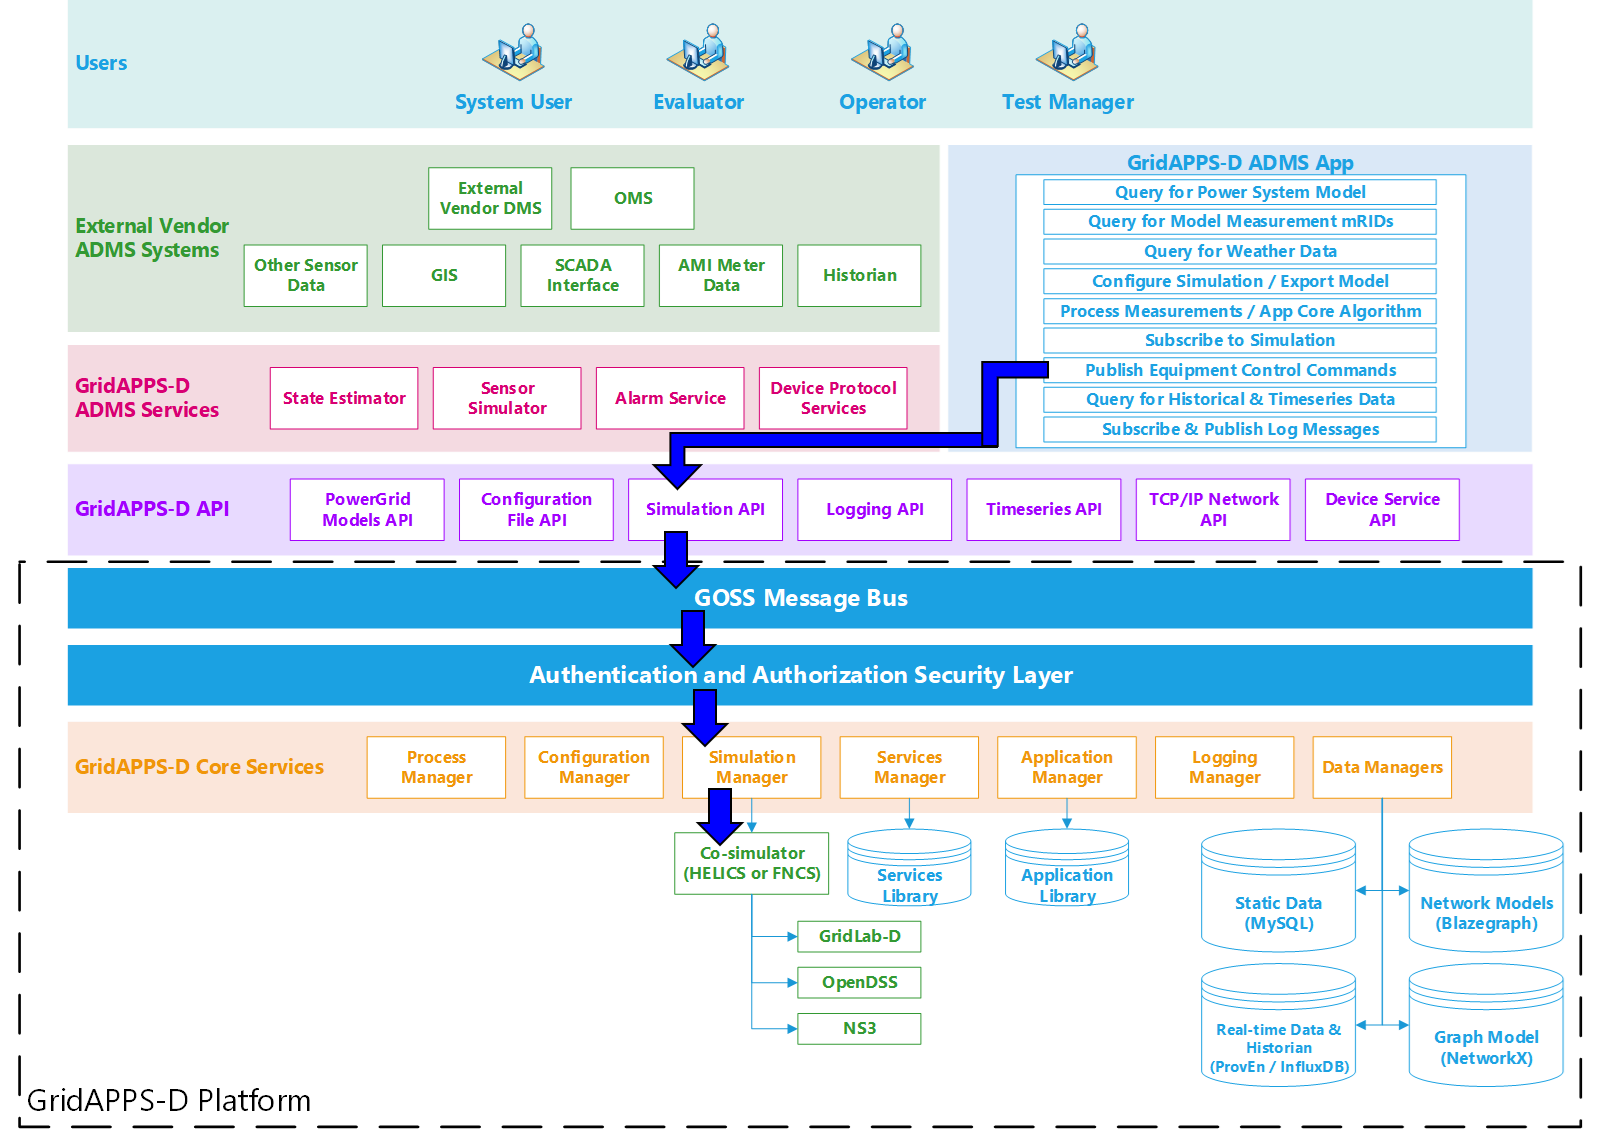

### 8.2. Sample App Code

Below is an example of an app code block 

In [ ]:
import time
from gridappsd import DifferenceBuilder
from gridappsd.topics import simulation_input_topic

input_topic = simulation_input_topic(viz_simulation_id)

my_open_diff = DifferenceBuilder(viz_simulation_id)
my_open_diff.add_difference(sw_mrid, "Switch.open", 1, 0) # Open switch given by sw_mrid
open_message = my_open_diff.get_message()

my_close_diff = DifferenceBuilder(viz_simulation_id)
my_close_diff.add_difference(sw_mrid, "Switch.open", 0, 1) # Close switch given by sw_mrid
close_message = my_close_diff.get_message()

while True:
    time.sleep(5)
    gapps.send(input_topic, open_message)
    time.sleep(5)
    gapps.send(input_topic, close_message)

In [ ]:
open_message